## Leitor de Respostas
Alunos: Pedro Dalla e Luiz Otávio

O trabalho realiza as seguintes etapas para realizar a leitura do gabarito:

#### Leitura e pré-processamento da imagem: 
    - É feita a leitura da imagem.
    - Transformamos para escala de cinza.
    - Aplicamos um borramento Gaussiano para reduzir ruído e facilitar identificação das bordas.
    - Binarizamos a imagem.
#### Rotação da imagem:
Precisamos identificar uma possível rotação na imagem de entrada e desrotacioná-la se for o caso.
    - Utilizamos o detector de cantos de Canny (utilizando cv2.Canny()).
    - Com o cantos identificados, encontramos linhas na imagem (utilizando cv2.HoughLinesP).
    - Então, calculamos o ângulo dessas linhas. Assim temos o ângulo de rotação da imagem.
    - Rotacionamos a imagem afim de deixá-la alinhada.
#### Encontrando os retângulos:
Utilizaremos os retângulos pretos da vertical e horizontal como referência.
    - Como os retângulos estão alinhados, encontramos os contornos na imagem (cv2.findContours()).
    - Utilizamos algumas heurísticas para identificar quais dos contornos encontrados são os retângulos pretos.
#### Identificando as marcações:
Com os retângulos encontrados combinaremos suas coordenadas para encontrar a posição de cada retângulo de resposta.
    - Utilizamos os x's dos blocos pretos das colunas com os y's dos blocos das linhas para encontrar o bloco da resposta.
    - Contamos os pixels pretos do retângulo. Caso atenda um certo limiar, consideramos-o marcado.
    - É então exibida a resposta selecionada (A até E), Branco ou Nulo, se for o caso.

In [7]:
import math
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
import cv2

IMAGE_INPUT_PATH = 'data/pattern_0002_scan_rotate.png'

MAP_ANSWER = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E'
}

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def rectsFilter(arr, pos, length):
    v = []
    for i, a in enumerate(arr):
        if len(v) == length:
            break
        if len(v) > 0:
            if a[pos]-10 <= v[0][pos] <= a[pos]+10:
                a_size = a[2] + a[3]
                v_size = v[0][2] + v[0][3]
                if a_size-10 <= v_size <= a_size+10:
                    v.append(a)
            else:
                del v[:]
                if a[2] + a[3] > 50:
                    v.append(a)
        else:
            if a[2] + a[3] > 50:
                v.append(a)
    return v
    

In [8]:
img  = cv2.imread(IMAGE_INPUT_PATH)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]

edges = cv2.Canny(thresh, 0.1, 1)

rho = 1               # distance resolution in pixels of the Hough grid
theta = np.pi / 180   # angular resolution in radians of the Hough grid
threshold = 150       # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 50     # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of   detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    angle_radians = math.atan2(lines[1][0][3]-lines[1][0][1], lines[1][0][2]-lines[1][0][0])
    angle_degrees = angle_radians * (180.0/math.pi)

    thresh = rotateImage(thresh, angle_degrees)
    img = rotateImage(img, angle_degrees)
    break

(_,contours,_) = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rects = []
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    rects.append([x, y, w, h])

# order by X 
rects = sorted(rects, key=lambda x: x[0])
# filter 15 rects by X
lines = rectsFilter(rects, 0, 15)
lines = sorted(lines, key=lambda x: x[1])

# order by Y
rects = sorted(rects, key=lambda x: x[1])
# filter 12 rects by Y
columns = rectsFilter(rects, 1, 12)
columns = sorted(columns, key=lambda x: x[0])

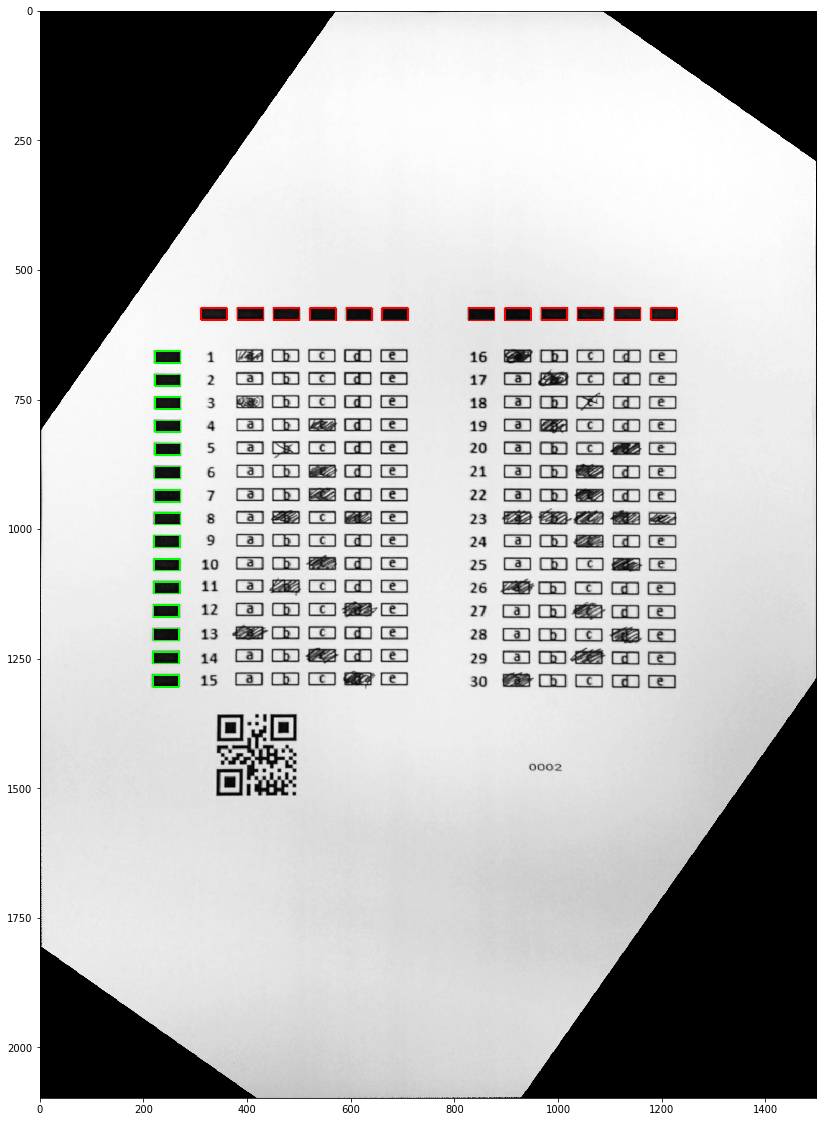

In [9]:
plt.rcParams['figure.figsize'] = [30, 20]
for v in lines:
    cv2.rectangle(img, (v[0], v[1]), (v[0]+v[2], v[1]+v[3]), (0, 255, 0), 2)
for h in columns:
    cv2.rectangle(img, (h[0], h[1]), (h[0]+v[2], h[1]+h[3]), (255, 0, 0), 2)
plt.imshow(img)
plt.show()

In [10]:
ret, img2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

for k, ranges in zip([0,1], [(1,6), (7,12)]):
    for i in range(15):
        curr_question = (i + 1) + (15 * k)
        question_opts = []
        for j in range(ranges[0], ranges[1]):
            x_begin = columns[j][0]
            x_end = x_begin + columns[j][2]
            y_begin = lines[i][1]
            y_end = y_begin + lines[i][3]
            answer_block = img2[y_begin:y_end,x_begin:x_end]
            filled_prop = answer_block.sum()/ (255*len(answer_block))
            question_opts.append(filled_prop)

        answers_found = []

        for a,x in enumerate(question_opts):
            if x < 80:
                answers_found.append(a)
        
        if len(answers_found) == 1:
            print(f'{curr_question}: {MAP_ANSWER[answers_found[0]]}')
        elif len(answers_found) == 0:        
            print(f'{curr_question}: Branco')
        elif len(answers_found) > 1:
            print(f'{curr_question}: Nulo')

1: A
2: Branco
3: A
4: C
5: Branco
6: C
7: C
8: Nulo
9: Branco
10: C
11: B
12: D
13: A
14: C
15: D
16: A
17: B
18: Branco
19: B
20: D
21: C
22: C
23: Nulo
24: C
25: D
26: A
27: C
28: D
29: C
30: A
